# IMA 208 TP5: homography estimation

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In this practical work, we will study how to estimate an homography between two given images. We will consider both the simple DLT algorithm (part I) and the RANSAC algorithm (part II).

To reduce the time you need for this practical work, we will use a few pre-implemented functions of openCV. Make sure that your library installation is correct before starting to work.

# Part 1: homography estimation from hand-selected keypoints: DLT algorithm

We assume that we have an image of a documents suffering from severe perspective distortion. The objective of this part is to warp this image (denoted in the following as img2) to remove the distortion using a reference image beeing in the desired pose (denoted as img1).

The following cell enables to vizualize the images using openCV.

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x21dc53d13d0>)

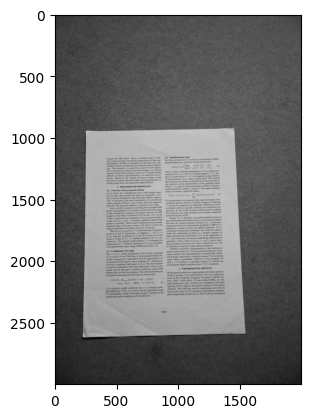

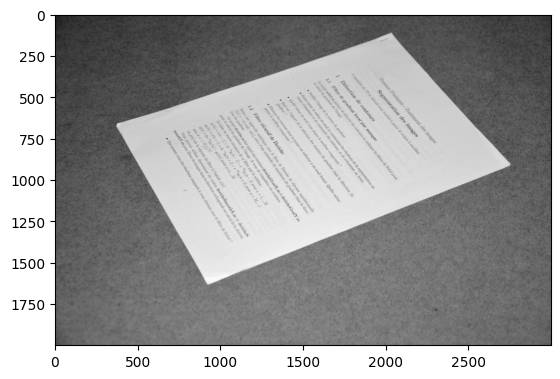

In [50]:
img1 = cv2.cvtColor(cv2.imread('Feuille_redressee.jpg'),cv2.COLOR_BGR2GRAY) # Reference image
img2 = cv2.cvtColor(cv2.imread('Feuille.jpg'),cv2.COLOR_BGR2GRAY) # Image to be processed

plt.figure(),plt.imshow(img1,cmap='gray')
plt.figure(),plt.imshow(img2,cmap='gray')

To correct the homography beetween the to images, we will need some points to match between the two images.

**Question:** how many points do you at least need to estimate the homography? Why?

**Answer:**

1. A minimum of four point correspondences between two images is required to estimate a homography matrix because the matrix has eight degrees of freedom.
2. Each point correspondence provides two equations, one for the x-coordinate and one for the y-coordinate, totaling eight equations needed to solve for the eight unknowns in the homography matrix.
3. Using more than four points and employing methods like RANSAC can improve the robustness of the homography estimation, especially in the presence of noise and outliers.

**Implementation:** to estimate the homography, some matching keypoints between the reference image and the to-be-porcessed one are given below. They here correspond to the corners of the two documents.

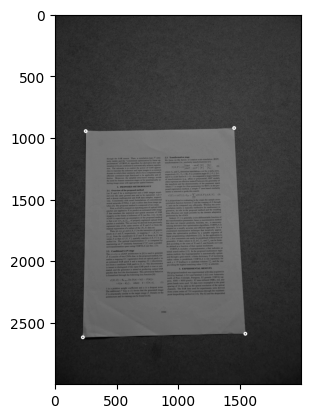

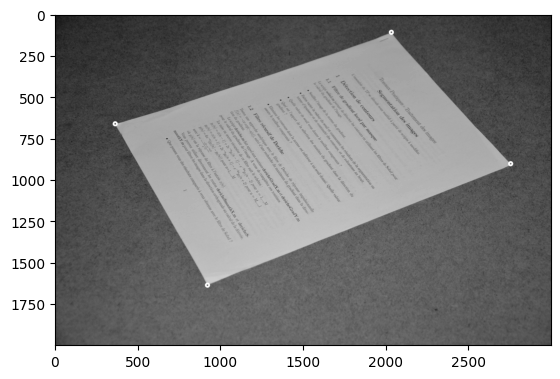

In [51]:
pts1 = [[248,949],[1450,924],[1541,2592],[225,2621]] # Keypoints for img1. Should be a list in format [[first_point_row,first_point_column],[second_point_row,second_point_column],...]
pts2 = [[2030,110],[2750,904],[920,1638],[363,663]] # Keypoints for img2,  keep the same order of the points as pts1.

# Below, we convert the points you found above into cv2 points object for vizualization (no need to change anything)
kp1 = [cv2.KeyPoint(pt[0], pt[1], 1) for pt in pts1]
kp2 = [cv2.KeyPoint(pt[0], pt[1], 1) for pt in pts2]

for i in range(len(pts1)):
    img1c=cv2.circle(img1,pts1[i],radius=10,color=(255,0,0),thickness=10)
plt.figure(),plt.imshow(img1c,cmap='gray')

for i in range(len(pts2)):
    img2c=cv2.circle(img2,pts2[i],radius=10,color=(255,0,0),thickness=10)
plt.figure(),plt.imshow(img2c,cmap='gray')

pts1 = np.array(pts1).T # In all the following, we will use the convention that np.shape(pts1) = [2,number_of_points]
pts2 = np.array(pts2).T # In all the following, we will use the convention that np.shape(pts1) = [2,number_of_points

**Visualize** the keypoints you found above to check that they are properly assigned.

Now, we will start implementing the DLT.

**Question:** recall what the DLT is. Give a pseudo code. What are its potential flaws and strengths?

**Answer:**

The Direct Linear Transform (DLT) algorithm is used to compute the homography that best maps a set of points in one image to a corresponding set of points in another image. The DLT is based on linear algebra, solving a set of linear equations derived from point correspondences to find the homography matrix.

Here is a simplified pseudo-code for the DLT algorithm:

```python
Function DLT(point_pairs):
    # point_pairs: list of pairs of corresponding points (pt1, pt2)

    A = empty matrix with dimensions (2*number_of_point_pairs, 9)

    for each (pt1, pt2) in point_pairs:
        # Construct the matrix A using the correspondence (pt1 <--> pt2)
        A.append([pt1.x, pt1.y, 1, 0, 0, 0, -pt2.x * pt1.x, -pt2.x * pt1.y, -pt2.x])
        A.append([0, 0, 0, pt1.x, pt1.y, 1, -pt2.y * pt1.x, -pt2.y * pt1.y, -pt2.y])

    # Perform Singular Value Decomposition on A
    U, S, Vt = SVD(A)

    # The last column of V (or row of Vt) gives the homography (reshaped to 3x3)
    H = reshape(Vt[-1], (3, 3))

    # Normalize H to ensure that the bottom-right value is 1
    H = H / H[2, 2]

    return H
```

**Strengths of the DLT:**

- **Simplicity**: The DLT algorithm is conceptually simple and straightforward to implement.
- **Robustness**: When used with RANSAC, the DLT can be robust to outliers.
- **Generality**: It can be applied to any set of point correspondences, regardless of the scene geometry.
- **Efficiency**: Solving the homography requires only a single SVD, which is a well-optimized linear algebra operation.

**Potential Flaws of the DLT:**

- **Sensitivity to Noise**: Without robust techniques like RANSAC, DLT is sensitive to noise and outliers in the point correspondences.
- **Non-linear Effects**: The DLT assumes a linear model, which doesn't take into account potential non-linear distortions such as lens distortion.
- **Conditioning**: If the points are collinear or in a degenerate configuration, the A matrix may be poorly conditioned, leading to an inaccurate homography.
- **Scale Ambiguity**: The computed homography is up to a scale. If normalization isn't handled properly, the scale ambiguity can lead to an incorrect homography.
- **Homogeneous Coordinates**: The use of homogeneous coordinates can introduce numerical instability if not handled with care, especially if the points are far from the origin. 

The first step of the DLT algorithm is to normalize the image point.

**Question:** Recall why the normalization is important. Recall how to do it.

**Answer:**

Normalization in the context of the Direct Linear Transform (DLT) algorithm is crucial for achieving numerical stability and accuracy when estimating a homography. The normalization process involves translating and scaling the image points so that the centroid of the points is at the origin and the average distance to the points is $ \sqrt{2} $. This step ensures the point data is well-conditioned, leading to a more reliable homography computation. The normalization and subsequent denormalization are achieved using a specific transformation matrix $ T $ that applies the translation and scaling to the points.

In the following, we will perform the normalization using the so called *homogeneous* coordinates of the keypoints. The main idea is to add a last coordinate equal to one for each point. The point (x,y) thus becomes (x,y,1) in homogeneous coordinate.

The advantage is that we will be able to do the normalization using a simple matrix product : X_norm = T@X.

**Fill** the blanks in the below implementation.

In [52]:
def normalize_image_points(imageEucl):
    """
    Input: 2D list with x,y image points
    Output: normalized data points
    """

    print("Normalizing data using similarity matrix...")

    # Step 1: Compute the mean of the points to find the centroid.
    mean = np.mean(imageEucl, axis=1)
    
    # Step 2: Translate points to put the centroid at the origin.
    translated_points = imageEucl - mean[:, np.newaxis]
    
    # Step 3: Compute the average distance of the points from the origin.
    distances = np.sqrt(np.sum(translated_points**2, axis=0))
    avg_dist = np.mean(distances)
    
    # Step 4: Calculate the scale factor to normalize the average distance to sqrt(2).
    scale = np.sqrt(2) / avg_dist
    
    # Step 5: Create the transformation matrix combining translation and scaling.
    Transformation = np.array([[scale, 0, -scale*mean[0]],
                               [0, scale, -scale*mean[1]],
                               [0, 0, 1]])
    
    # Step 6: Convert points to homogeneous coordinates for transformation.
    ones = np.ones((1, imageEucl.shape[1]))
    image_homogeneous = np.vstack((imageEucl, ones))
    
    # Apply the transformation.
    image_norm_homogeneous = np.dot(Transformation, image_homogeneous)
    
    # Step 7: Convert back from homogeneous coordinates.
    image_norm = image_norm_homogeneous[:2, :]

    return image_norm, Transformation


**Question:** Verify that your data looks properly normalized.

In [53]:
normalize_image_points(np.array(pts1))

Normalizing data using similarity matrix...


(array([[-0.83540794,  0.78944699,  0.91246013, -0.86649918],
        [-1.11184957, -1.14564439,  1.10914598,  1.14834797]]),
 array([[ 1.35179279e-03,  0.00000000e+00, -1.17065255e+00],
        [ 0.00000000e+00,  1.35179279e-03, -2.39470092e+00],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]))

The second step is to compute the A matrix from the normalized data points.

**Fill** the blanks in the function below.

**Question:** justify the shape of the A matrix.

**Answer:**

The shape of $ A $ is $ 2n \times 9 $ because each point correspondence provides two equations, which form two rows in $ A $, and there are 8 degrees of freedom in $ H $ plus one scale factor, totaling 9 columns in $ A $. Each row in $ A $ corresponds to one linearized equation derived from the relationship enforced by the homography transformation. The system is solved using Singular Value Decomposition (SVD), where the solution corresponds to the eigenvector associated with the smallest singular value, reshaped into a 3x3 matrix to get $ H $. This setup of $ A $ enables a linear solution to a problem that would otherwise be nonlinear due to the division operation in the projective transformation.

In [54]:
def compute_matrix_A(points1, points2, no_points):
    """
    Input: Already normalized correspondences for image1 and image2
    Output: Matrix A as defined in Zisserman p. 91
    """

    A = []

    for i in range(0, no_points):
        x, y = points1[0, i], points1[1, i] # Denote the coordinate in image 1 x and y for shortcut
        x_prime, y_prime = points2[0, i], points2[1, i] # Denote the coordinate in image 2 x_prime and y_prime for shortcut

        # Create A_i according to the fomula given in class
        # here we are assuming w_i and w_i_prime are one
        A.append([0, 0, 0, -x, -y, -1, y_prime*x, y_prime*y, y_prime])
        A.append([x, y, 1, 0, 0, 0, -x_prime*x, -x_prime*y, -x_prime])
    
    A = np.asarray(A)  # Convert A to a numpy array for further processing.
    print()
    print("Stacked matrix A shape:", np.shape(A))

    return np.asarray(A)

We are now ready to code the whole homography computation function. 

**Fill** the gaps below.

In [55]:
def compute_homography(pts1,pts2):

    # Set data points to numpy arrays
    no_points = pts1.shape[1] # Number of points

    # Normalize the data
    image1_normalized, T = normalize_image_points(pts1)
    image2_normalized, T_prime = normalize_image_points(pts2)
    
    # Get matrix A
    # A = ...
    A = compute_matrix_A(image1_normalized, image2_normalized, no_points)

    # Compute SVD of A
    U, S, V = np.linalg.svd(A)
    V = V.T # So that A = USV.T
    
    # Get last column of V (this is the vector h)
    h = V[:, -1]
    
    # Obtain homography by reshaping h (H tilde)
    print()
    print("Reshaping to get homography H_tilde...")
    H_tilde = h.reshape(3, 3)

    # Denormalize to obtain homography (H) using the transformations and generalized pseudo-inverse
    H = np.linalg.inv(T_prime) @ H_tilde @ T

    print()
    print("Denormalized to obtain homography H for 2D data points...")
    print("Matrix H:")
    print(H)
    
    return H

**Question:** Apply the compute_homography function to warp the document image 2 into the perspective of document 1. Any comment ?

Normalizing data using similarity matrix...
Normalizing data using similarity matrix...

Stacked matrix A shape: (8, 9)

Reshaping to get homography H_tilde...

Denormalized to obtain homography H for 2D data points...
Matrix H:
[[ 1.92481559e-01 -6.26899812e-01  1.82602172e+03]
 [ 3.64030164e-01  2.10685140e-01 -2.20923513e+02]
 [-6.25855296e-05 -4.90036169e-06  6.50136791e-01]]


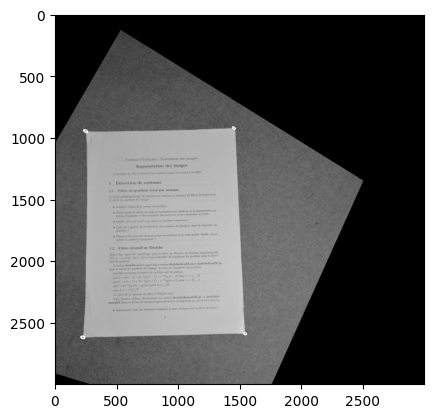

In [56]:
H = compute_homography(pts1,pts2)
homography_matrix_normalized = H
result = cv2.warpPerspective(img2, np.linalg.inv(homography_matrix_normalized),(3000,3000))
plt.imshow(result,cmap='gray')

**Answer:**

The warped image of the document appears to have been processed to correct perspective distortion, likely to align with a reference image. Key points to consider in assessing the result include the alignment of the text, the correctness of the aspect ratio, potential distortion, seamlessness in the context of a larger image composite, the sharpness of the text, and the overall quality of the transformation. Ensuring that the point correspondences used to compute the homography were accurate and well-distributed is crucial for a successful perspective correction. If any issues are visible in these areas, they would warrant further investigation and possible refinement of the process.

**Question:** test the sensitivity of the above algorithm to errors in the matching keypoints. Are you able to obtain good results if you have a false match?

Answer to the same question is you have more matching points than the corners.

**Answer:**

The accuracy of homography estimation is highly sensitive to errors in matching keypoints. A few false matches can be tolerated and often mitigated by robust estimation techniques such as RANSAC, which are designed to handle and reject outliers. However, the presence of multiple false matches, especially if they are spatially distributed across the image, can lead to significant errors in the resulting transformation. The quality of the results depends on the proportion of correct matches—good results are contingent on the majority of matches being accurate. If the algorithm lacks a robust mechanism to reject outliers, or if the number of false matches is substantial, the homography will be incorrect, and the warped image will have notable distortions.

Having more matching points than just the corners generally improves the robustness of homography estimation to errors in keypoint matching. More points provide additional data, allowing algorithms like RANSAC to better identify and discard outliers or false matches. This redundancy makes the computed homography more reliable and can result in a more accurate transformation, assuming that the majority of the matches are correct.

Normalizing data using similarity matrix...
Normalizing data using similarity matrix...

Stacked matrix A shape: (8, 9)

Reshaping to get homography H_tilde...

Denormalized to obtain homography H for 2D data points...
Matrix H:
[[ 1.11344927e+00 -3.92479310e-01  3.34402035e+02]
 [ 1.75964666e-01  4.07006204e-01 -3.24998234e+02]
 [ 1.80301975e-04  3.06611528e-04 -9.06838171e-02]]


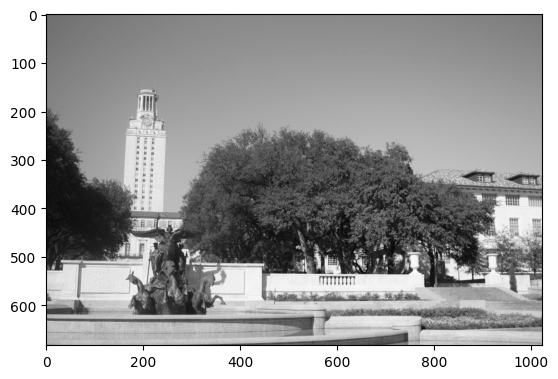

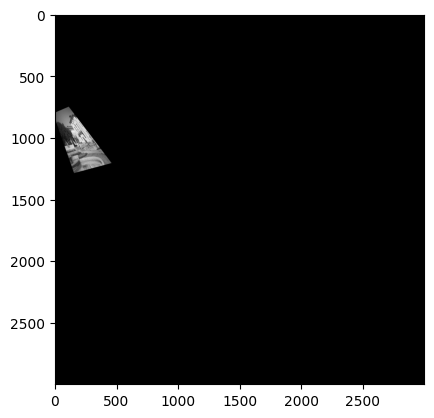

In [77]:
pts1 = [[289,729],[985,896],[1205,2369],[388,1456]]
pts2 = [[2001,122],[2985,589],[875,998],[458,789]]

for i in range(len(pts1)):
    img1c_dec=cv2.circle(img1,pts1[i],radius=10,color=(255,0,0),thickness=10)
plt.figure(),plt.imshow(img1c_dec,cmap='gray')

for i in range(len(pts2)):
    img2c_dec=cv2.circle(img2,pts2[i],radius=10,color=(255,0,0),thickness=10)
plt.figure(),plt.imshow(img2c_dec,cmap='gray')

pts1 = np.array(pts1).T # In all the following, we will use the convention that np.shape(pts1) = [2xnumber_of_points]
pts2 = np.array(pts2).T # In all the following, we will use the convention that np.shape(pts1) = [2xnumber_of_points

H = compute_homography(pts1,pts2)
homography_matrix_normalized = H / H[2, 2]
result = cv2.warpPerspective(img2, np.linalg.inv(homography_matrix_normalized),(3000,3000))
plt.imshow(result,cmap='gray')

# Part 2: automatic homography estimation and panorama stitching

To bypass the flaws that we observed with the previous method, we now propose to use a robust homography estimation method, the RANSAC algorithm. As an application, we will consider panorama stitching: from two given overlapping images, create a single one which is a panorama. To do that, we will need to estimate the best homography to warp an image into the perspective of the other. In addition, to avoid the cumbersome choice of the matching points between the two images, we will do an automatic keypoint identification by using the SIFT features.

Let us first load the two considered images.

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x21dc5a46c90>)

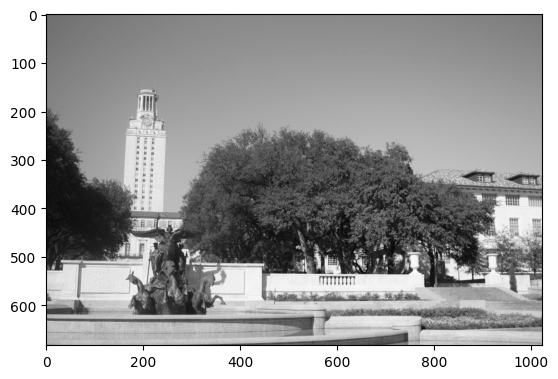

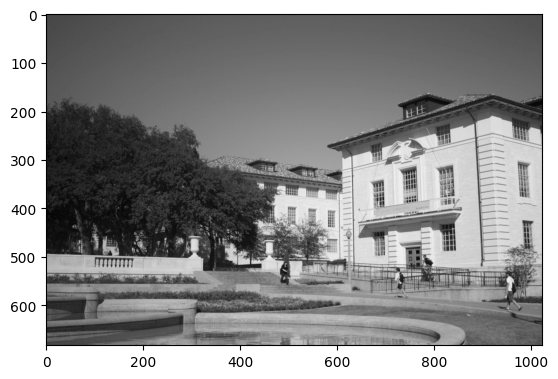

In [58]:
img1c = cv2.cvtColor(cv2.imread('uttower_left.jpg'),cv2.COLOR_BGR2GRAY)
img2c = cv2.cvtColor(cv2.imread('uttower_right.jpg'),cv2.COLOR_BGR2GRAY)

img1 = img1c
img2 = img2c

plt.figure(),plt.imshow(img1,cmap='gray')
plt.figure(),plt.imshow(img2,cmap='gray')

To stitch the two images, we need to have access to pair of corresponding points between image 1 and image 2. To do that, we first need to extract some keypoints in both images (that will be matched later on). We will use here the SIFT descriptors.

**Implement** the SIFT descriptors for both image 1 and image 2. You might be willing to use the cv2.SIFT_create and sift.detectAndCompute.

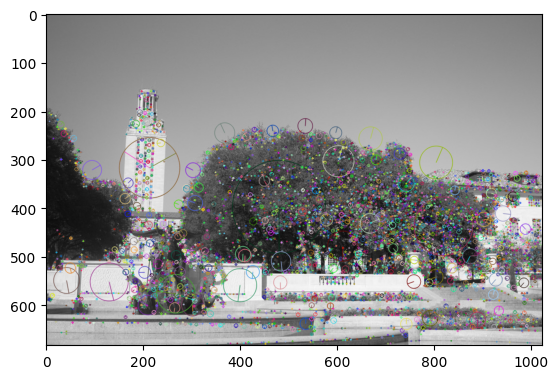

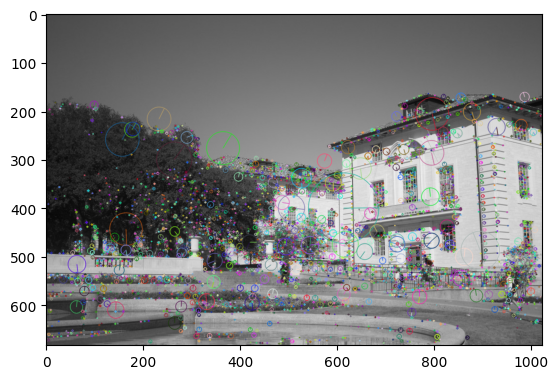

In [59]:
sift = cv2.SIFT_create() # Creates an object of the SIFT class. The larger the threshold, the smaller the number of points
kp1,desc1 = sift.detectAndCompute(img1, None) #kp1 = location of the keypoints, desc1 = corresponding descriptors.

# For visualization
img1c=cv2.drawKeypoints(img1,kp1,img1c,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img1c)
plt.show()

kp2,desc2 = sift.detectAndCompute(img2, None) #kp2 = location of the keypoints, desc2 = corresponding descriptors.
img2c=cv2.drawKeypoints(img2,kp2,img2c,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img2c)

**Question:** explain the shapes of desc1, kp1 and desc2, kp2 and their respective roles.

**Answer:**

`kp1` and `kp2` are lists of keypoints detected in the first and second images, respectively, containing information like location, scale, and orientation of each feature. They don't have a numpy shape but a length equal to the number of detected features.

`desc1` and `desc2` are arrays where each row corresponds to a descriptor for the keypoints in `kp1` and `kp2`. Their shape is `(n, 128)` and `(m, 128)`, with `n` and `m` being the count of keypoints in each image, and 128 representing the dimensionality of the SIFT descriptor.

The keypoints are used for their spatial and scale information, while the descriptors allow for the actual matching of keypoints between two images. Together, they facilitate the identification of corresponding points across images, which can be used to compute transformations like homographies.

Now that we have obtained the SIFT descriptor, we have to match them.

**Complete** the following code.

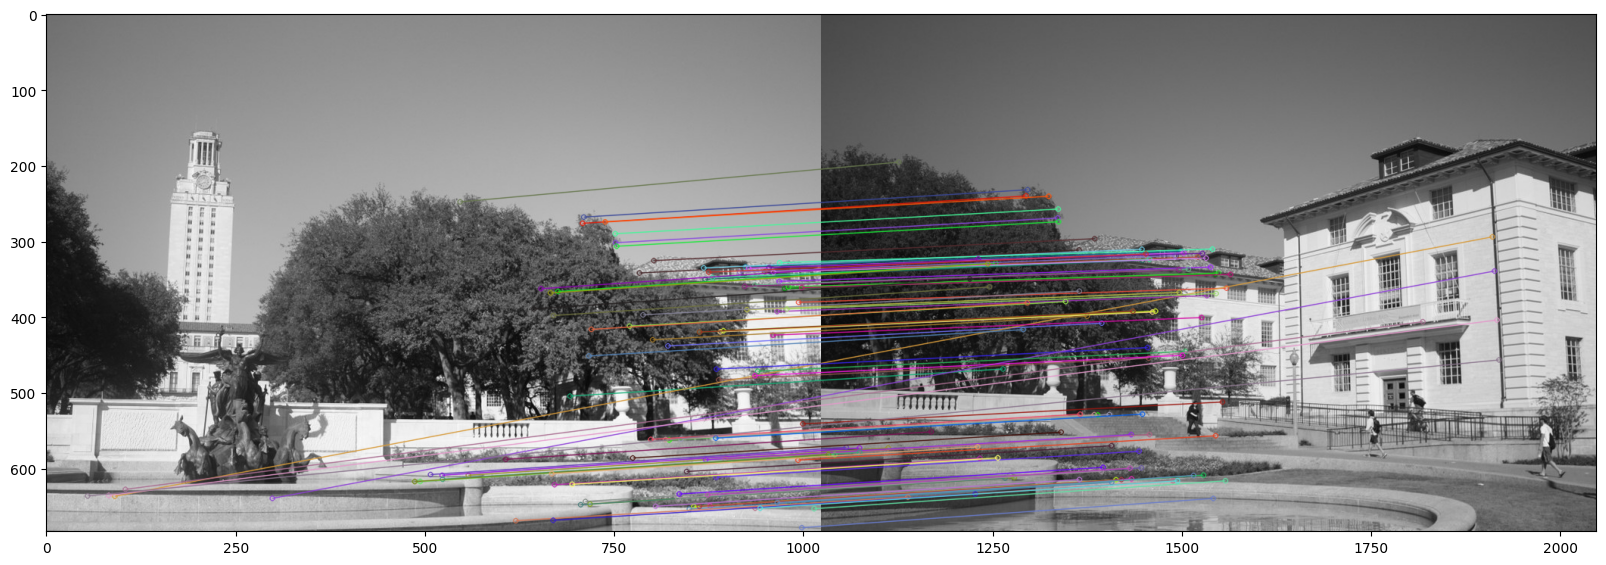

(<Figure size 2000x1200 with 1 Axes>,
 None)

In [60]:
#feature matching
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

matches = bf.match(desc1,desc2) 

matches = sorted(matches, key=lambda x: x.distance) # Sort matches based on feature distance

# For visualizing the matches
img3 = cv2.drawMatches(img1, kp1, img2, kp2, matches[:100], img2, flags=2)
plt.figure(figsize=(20,12)),plt.imshow(img3),plt.show()

**Question:** comment the match quality. Do you think that the previous matching would enable a decent homography computation using the DLT algorithm of the first part?

**Answer:**

The image appears to show keypoint matches between two photographs, likely as part of a feature matching step in a panorama stitching or image alignment algorithm. The colored lines connecting pairs of keypoints across the two images represent individual matches. 

In a high-quality match set:

- Matches should generally be consistent in geometric transformation, meaning that the lines should not intersect too much and should reflect the relative motion of the camera between the shots.
- Correct matches are usually distributed across the whole image, not clustered in one area.
- The lines should follow the same direction if the images have been taken from similar viewpoints or with minimal rotation.

Judging from the image, there seem to be a mixture of good and potentially bad matches. Some lines are parallel, suggesting correct correspondences, while others are intersecting or not following the general pattern, suggesting potential mismatches.

If these matches were to be used for a Direct Linear Transform (DLT) for homography estimation:

- **With Robust Estimation (e.g., RANSAC)**: The algorithm might still compute a decent homography by identifying and ignoring the outliers (false matches) and using only the inliers (true matches) to compute the transformation.
- **Without Robust Estimation**: The presence of false matches would likely lead to an incorrect homography, resulting in a poor image alignment.

Thus, the quality of the DLT homography estimation will heavily depend on the robustness of the matching algorithm and the ability to filter out incorrect matches.

The following code enables to keep only the coordinates of the 100 best matches in the two images. We will use them as an input of a RANSAC, which will enable to do a robust homography estimation between the two images.

In [61]:
D1 = np.ones((2,100)) # Coordinates in image 1 of the first best matching points
D2 = np.ones((2,100)) # Coordinates in image 2 of the first best matching points
for ii in range(100):
    D1[:,ii] = kp1[matches[ii].queryIdx].pt
    D2[:,ii] = kp2[matches[ii].trainIdx].pt

D1 = D1.astype(int)
D2 = D2.astype(int)

In [62]:
print(D1.shape)

(2, 100)


Now, we are ready to code the RANSAC algorithm.

**Fill** the gaps in the code below.

In [63]:
def ransac(D1, D2, num, threshold, iterations):
    # D1, D2 : matched points between the two images
    # num : number of points to compute the homography
    # threshold : distance threshold for determining if a pair of point in an inlier or an outlier
    # iterations : number of iterations / number of sampling
    
    D1h = np.vstack((D1, np.ones((1, D1.shape[1]))))
    D2h = np.vstack((D2, np.ones((1, D2.shape[1]))))
    
    n = D1.shape[1]  # Number of points
    best_n_inlier = 0
    best_H = None  # Initialize best homography matrix
    
    for i in range(iterations):
        s = np.random.choice(n, num, replace=False)
        
        pts1 =  D1[:, s] #pts1 is the chosen points among D1
        pts2 =  D2[:, s] #pts2 is the chosen points among D2
        
        H = compute_homography(pts1, pts2) # Compute the corresponding homography. You can reuse the function of part I.
        
        D2_transformed  = np.dot(H, D1h) # Transform the points of D1h to be able to compare them to the ones of D2h
        
        # Normalize D2_new
        D2_transformed /= D2_transformed[2, :]
        
        SD = np.sum((D2h[:2, :] - D2_transformed[:2, :])**2, axis=0) # Compute the distance between D2_new and D2h
        
        inliers = SD < threshold**2 # Compute the inliers
        num_inlier = np.sum(inliers) # Compute the number of inliers
        
        if num_inlier > best_n_inlier: # If you obtained the best result, store the corresponding homography
            best_H = H
            best_n_inlier = num_inlier
            point1 = D1[:2, inliers]
            point2 = D2[:2, inliers]
            in_res = SD[inliers]
    
    
    return best_H, best_n_inlier, point1, point2, in_res

Using the function you implemented above, **launch the RANSAC algorithm** to estimate the homography between the two images.

In [64]:
threshold = 1;
num = 4;
iterations = 1000;
[H, inliers, point1, point2, residue] = ransac(D1, D2, num,threshold, iterations)

Normalizing data using similarity matrix...
Normalizing data using similarity matrix...

Stacked matrix A shape: (8, 9)

Reshaping to get homography H_tilde...

Denormalized to obtain homography H for 2D data points...
Matrix H:
[[ 6.27633005e-01 -3.59154935e-02 -2.81623982e+02]
 [ 9.08537240e-02  5.73955819e-01 -8.66270282e+01]
 [ 1.58678737e-04  1.15585190e-05  4.50500478e-01]]
Normalizing data using similarity matrix...
Normalizing data using similarity matrix...

Stacked matrix A shape: (8, 9)

Reshaping to get homography H_tilde...

Denormalized to obtain homography H for 2D data points...
Matrix H:
[[ 5.53584067e-01 -7.75253724e-02 -2.02311511e+02]
 [-5.49546602e-02  4.85844923e-01  7.47118613e+01]
 [-1.10251125e-04 -1.51582510e-04  7.47671679e-01]]
Normalizing data using similarity matrix...
Normalizing data using similarity matrix...

Stacked matrix A shape: (8, 9)

Reshaping to get homography H_tilde...

Denormalized to obtain homography H for 2D data points...
Matrix H:
[[ 6.

In [65]:
print(H)

[[ 6.13558456e-01 -3.84301297e-02 -2.69917034e+02]
 [ 7.97180644e-02  5.73113434e-01 -7.78041315e+01]
 [ 1.31538036e-04  1.80179704e-06  4.76427678e-01]]


Lastly, **fill the code** below to warp img2 into the same space as img1

In [70]:
result = cv2.warpPerspective(img2, H, (img1.shape[1] + img2.shape[1], img1.shape[0]))
result[0:img1.shape[0], 0:img1.shape[1]] = img1
result = np.uint8(result)

**Question:** Plot the panorama image. How good is it? Any comment?

(<Figure size 4000x2000 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x21de7ddd810>)

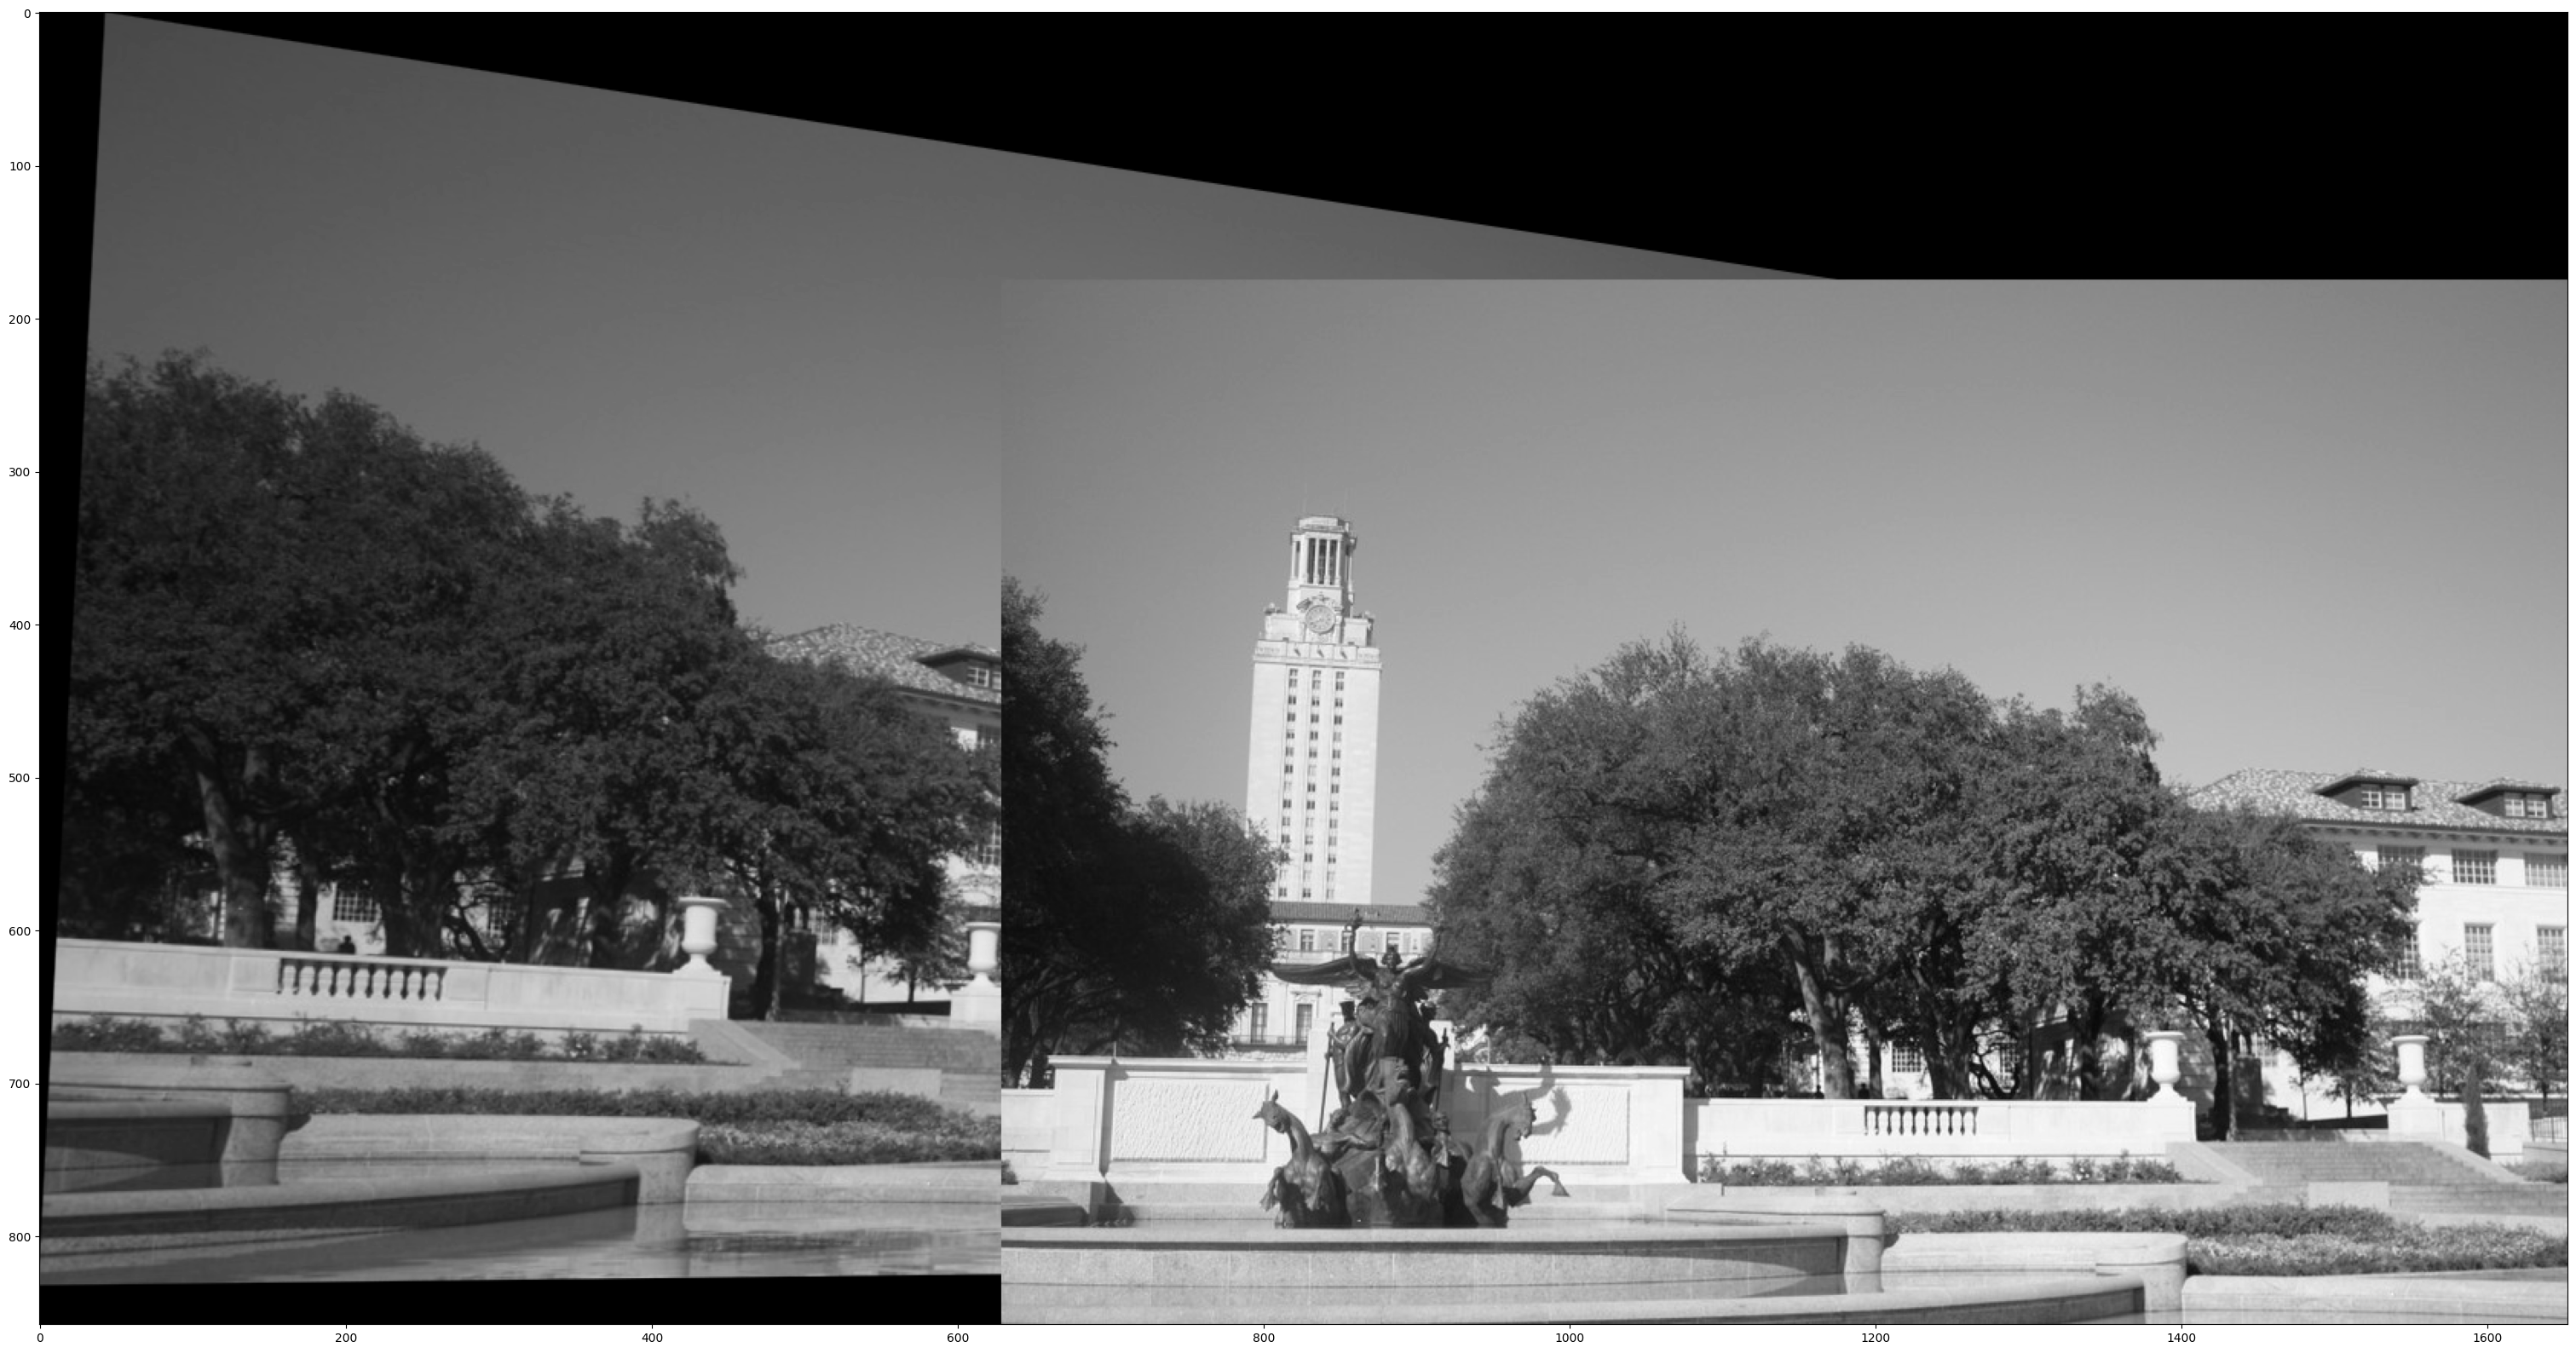

In [75]:
# Compute the size of the resulting panorama image
h1, w1 = img1.shape[:2]
h2, w2 = img2.shape[:2]
corners = np.float32([[0, 0], [w1, 0], [w1, h1], [0, h1]])
corners = np.array([corners])
warped_corners = cv2.perspectiveTransform(corners, H)
all_corners = np.concatenate((corners, warped_corners), axis=1)
[x_min, y_min] = np.int32(all_corners.min(axis=1).ravel() - 0.5)
[x_max, y_max] = np.int32(all_corners.max(axis=1).ravel() + 0.5)
translation_dist = [-x_min, -y_min]
H_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])

# Warp the images
result = cv2.warpPerspective(img2, H_translation.dot(H), (x_max - x_min, y_max - y_min))
result[translation_dist[1]:h1+translation_dist[1], translation_dist[0]:w1+translation_dist[0]] = img1

plt.figure(figsize=(40,20)),plt.imshow(result,cmap='gray')

**Answer:**

Overall the result is pretty bad.

1. **Alignment**: The transition between the stitched images should be smooth with no apparent misalignment.

2. **Seam Visibility**: A high-quality panorama will have seams that are either invisible or very difficult to detect. Visible seams could indicate improper alignment or variations in exposure and color balance between images.

3. **Distortion**: The image should be free from noticeable distortion that can arise from an incorrect homography. Objects and structures should appear as they do in reality, without bending or stretching.

4. **Exposure and Color Consistency**: The brightness and color across the panorama should be uniform, without noticeable differences. This might require exposure compensation or blending techniques if the original images had varying lighting conditions.

5. **Overall Aesthetic**: The panorama should be pleasing to view, with a wide field of view and a natural-looking perspective.

**Bonus**: try other descriptors than the SIFT ones. Try to implement your own.

**Bonus:** try to correct the change of luminosity between the two images so that the panorama look more realistic.

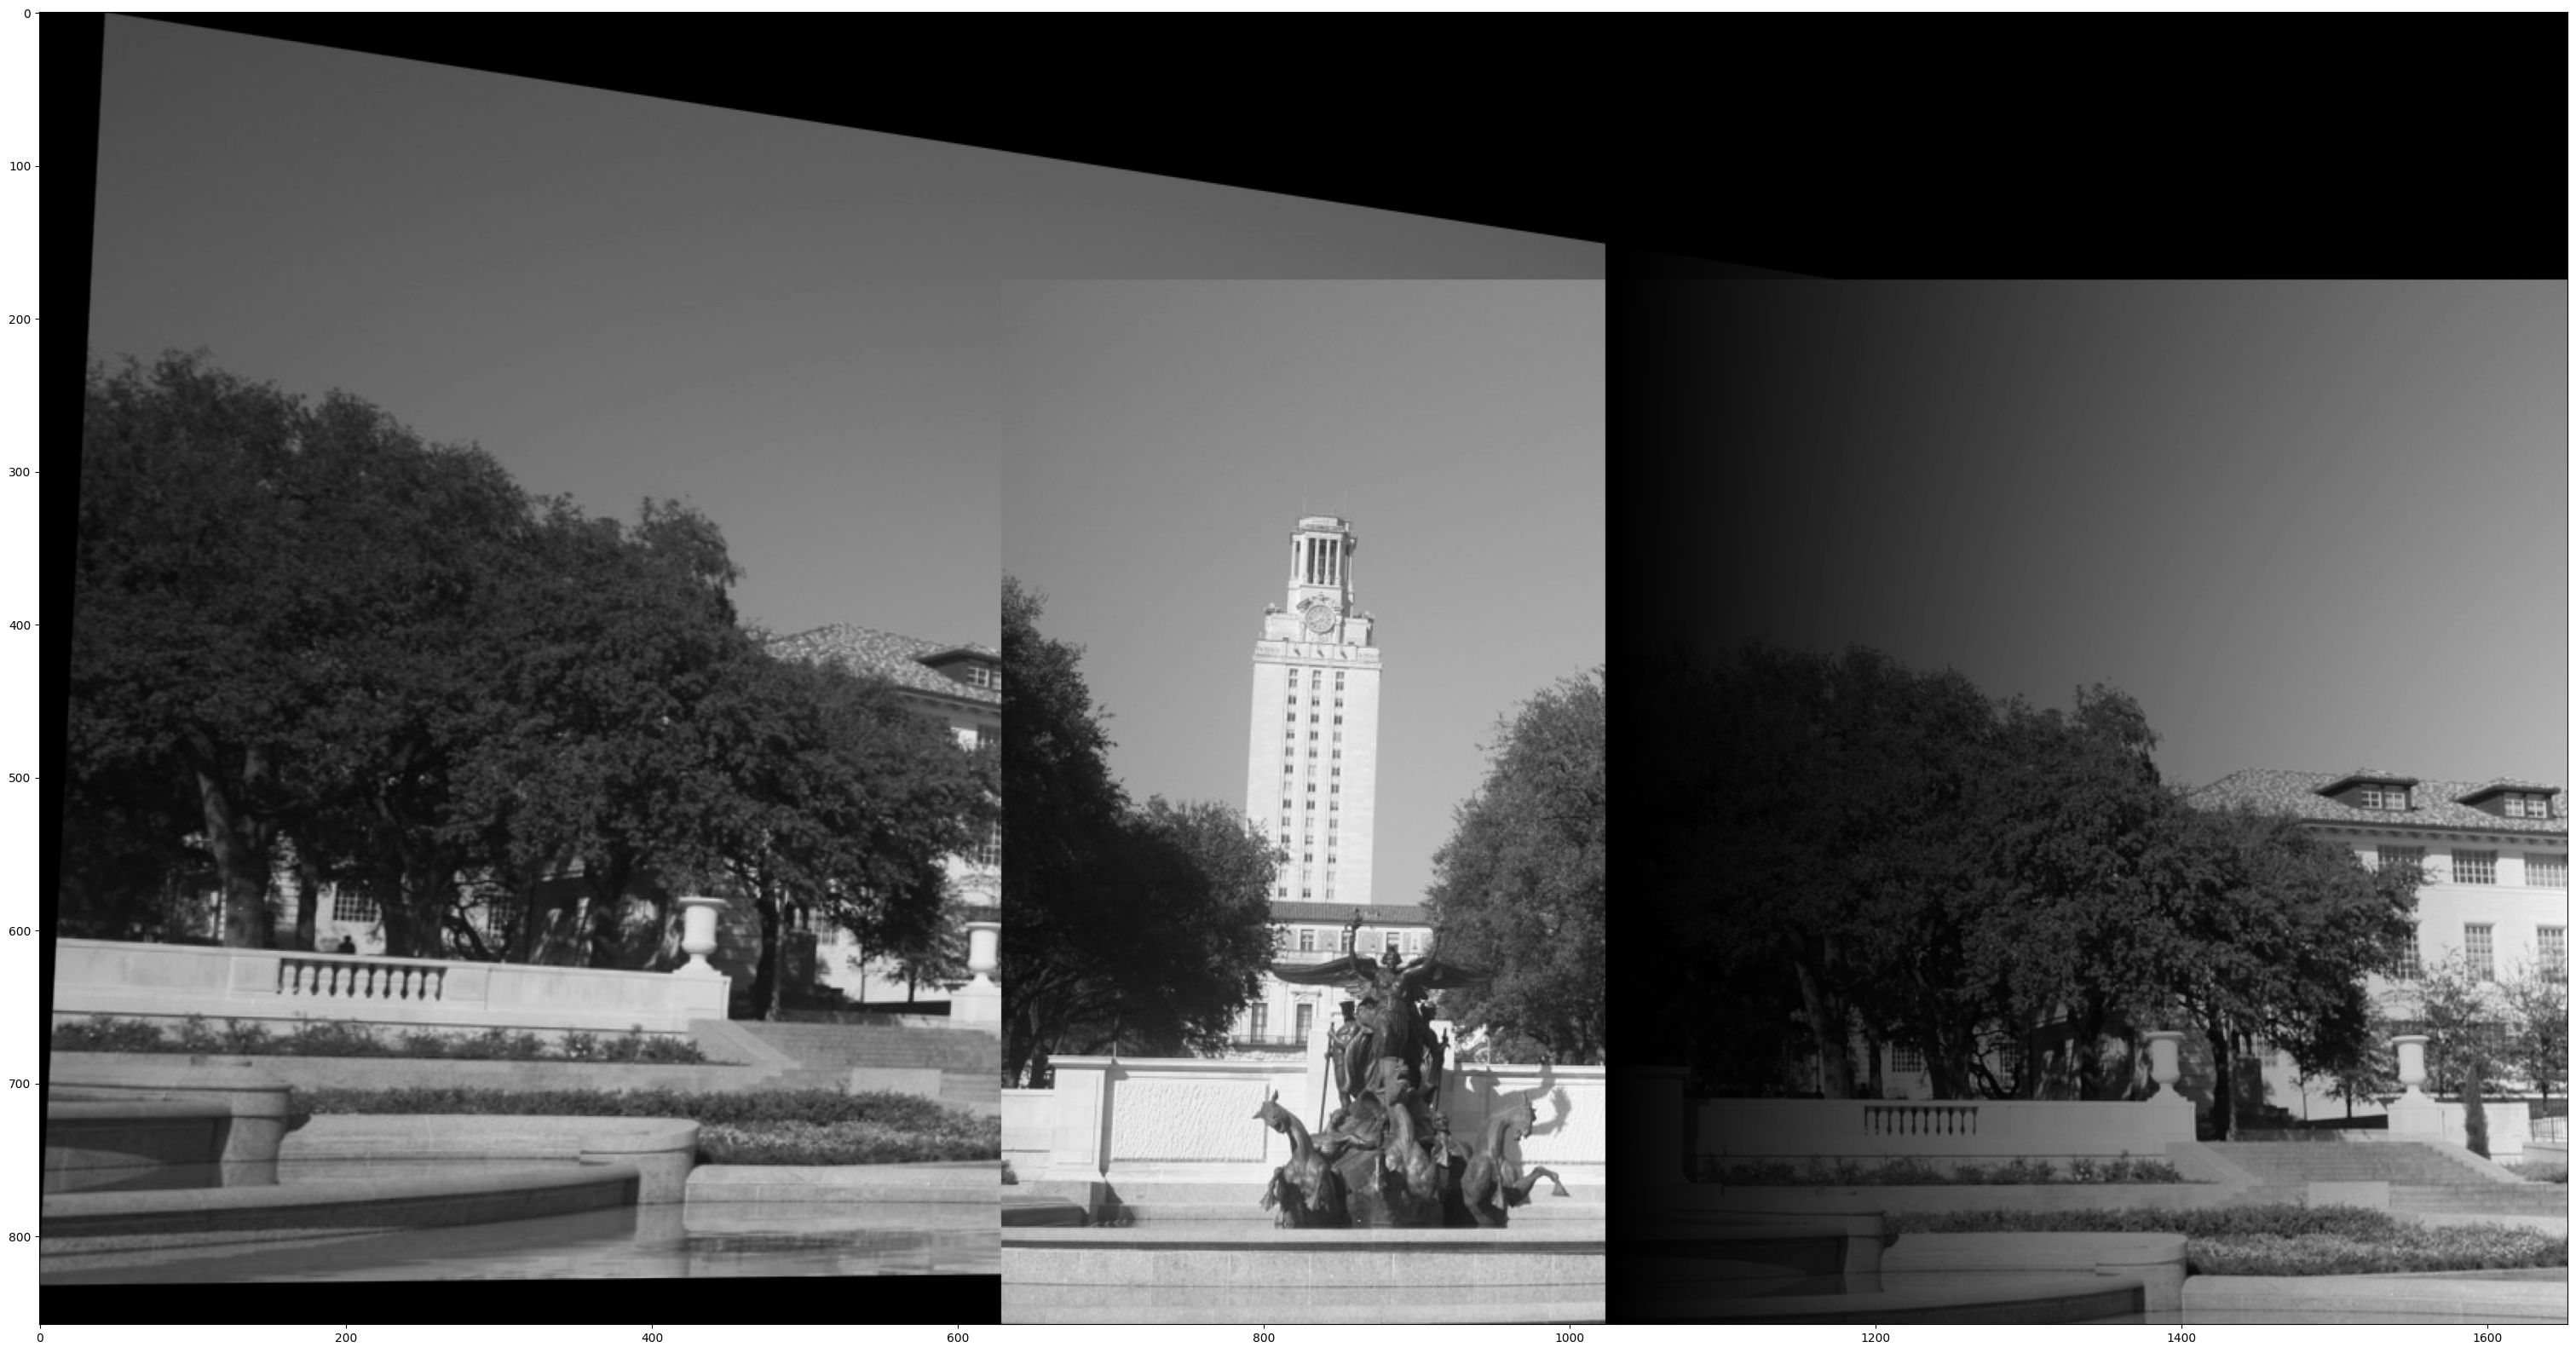

In [76]:
# Assuming result is your stitched image and img1 is the left image.
overlap_width = result.shape[1] - img1.shape[1]

# Create an alpha mask with linear gradient in the overlapping area.
alpha_mask = np.zeros_like(result, dtype=float)
for i in range(overlap_width):
    alpha_mask[:, img1.shape[1] + i] = i / overlap_width

# Ensure the left part is fully included from the first image.
alpha_mask[:, :img1.shape[1]] = 1

# Perform the blending
result_blended = (result * alpha_mask).astype(np.uint8)

# Plot the result
plt.figure(figsize=(40,20))
plt.imshow(result_blended, cmap='gray')
plt.show()